# Imports and Configurations

In [172]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from IPython.display import display
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

np.set_printoptions(precision=3, suppress=True)
ecm = make_scorer(mean_absolute_error)
ecm_name = 'mean_absolute_error'
k_fold_value = 5

raw_dataset = pd.read_csv('dataset_v1.csv', sep=',', skipinitialspace=True)
dataset = raw_dataset.copy()
predict_set = dataset.tail(20)
dataset = dataset.drop(predict_set.index)

predictors = ['SampleNo', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']

# Functions

In [173]:
# Utility Classes
class ModelResult:
    def __init__(self, info_dict: dict):
        self.model = info_dict['model']
        self.arg = info_dict['arg']
        self.predictors = info_dict['predictors']
        self.predicted = info_dict['predicted']
        self.error = info_dict['error']


class ModelResultsTable:
    def __init__(self):
        self.all_model_results = {}  # {'mul_lin_reg': [ModelResult0, ModelResult1, ...], 'lin_reg': [...] ... }
        self.model_results_with_best_params = []

    def add_model(self, model_results: list):
        sorted_models = list(sorted(model_results, key=lambda item: item.error))
        best_performing_var = sorted_models[0]
        self.all_model_results[best_performing_var.model] = sorted_models
        self.model_results_with_best_params.append(best_performing_var)
        self.model_results_with_best_params = list(sorted(self.model_results_with_best_params,
                                                          key=lambda item: item.error))

    def display_error_table(self, transpose=True):
        error_table = pd.DataFrame([[result.model, result.arg, result.predictors, result.error]
                                    for result in self.model_results_with_best_params],
                                   columns=['model', 'args', 'predictors', ecm_name])
        if transpose:
            error_table = error_table.transpose()
        display(error_table)


all_results_table = ModelResultsTable()

Before applying any machine learning algorithms, I wanted to see how each of the given predictors relate to each other.
To do it, I have found out pairplot() function from seaborn library which takes the name of columns (predictors) as
parameters and plots each one of them with another.

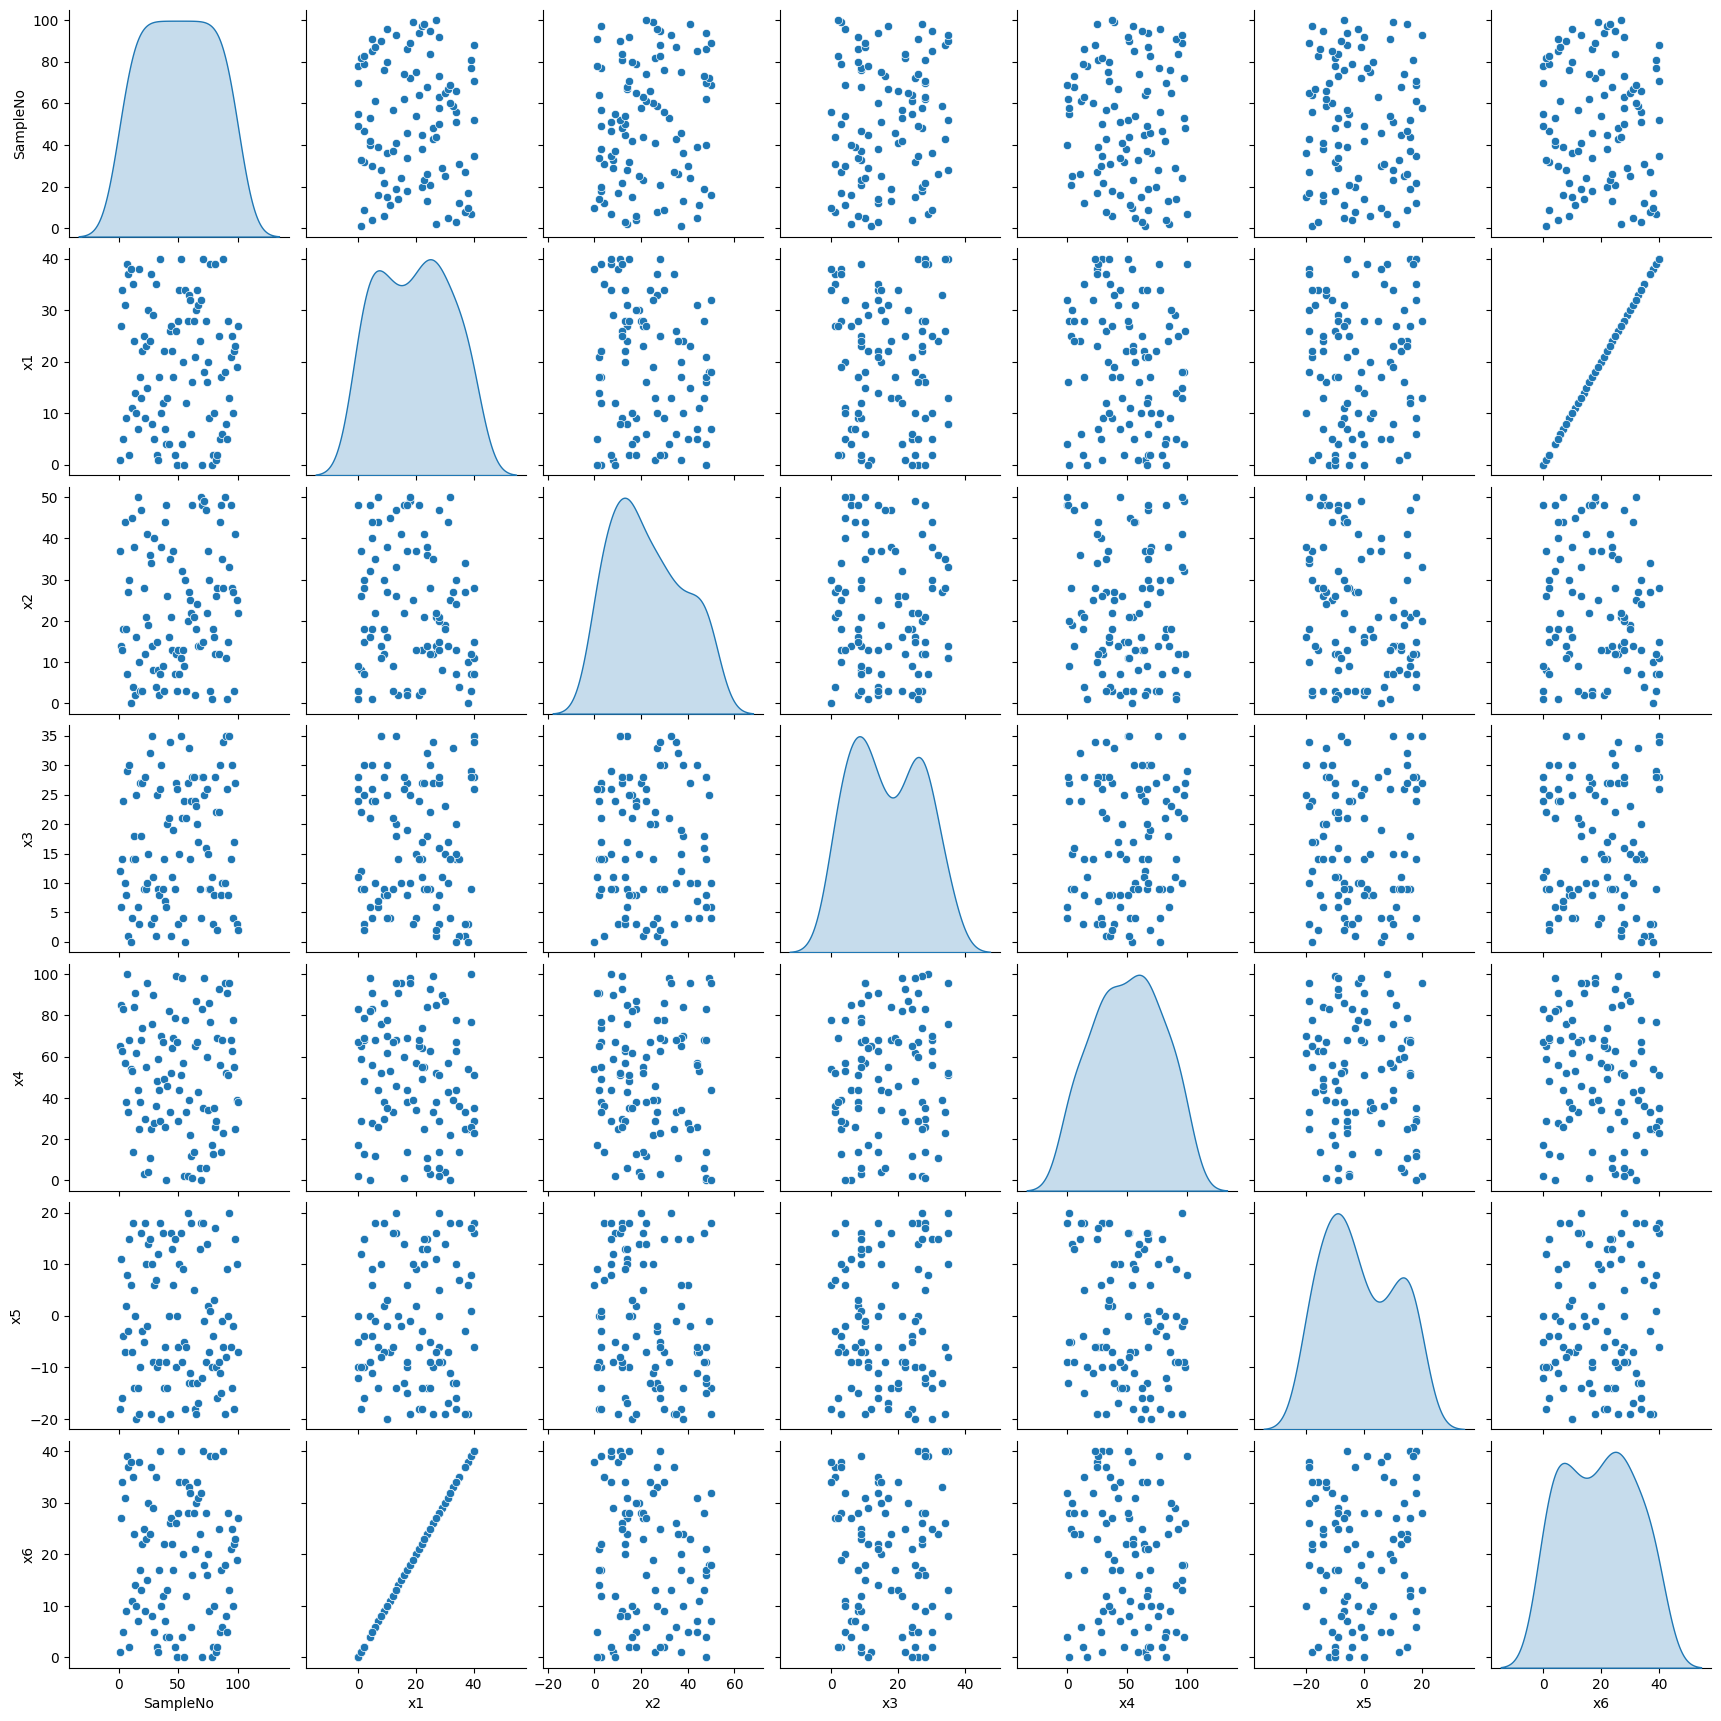

In [174]:
sns.pairplot(dataset[predictors], diag_kind='kde')

From looking at those results, it is clear that x1 and x6 values are exactly the same. So, I have decided to drop x6
predictor since we do not need the same values twice. Also, I have previously included SampleNo as a predictor (even it is
not really logical) just to see if it makes the algorithms perform better, which it obviously did not. So, I am also
dropping the SampleNo from the dataset and the predictors list.

In [175]:
dataset = dataset.drop('x6', axis=1)
predictors.remove('x6')

dataset = dataset.drop('SampleNo', axis=1)
predictors.remove('SampleNo')

# predictors = ['x1', 'x3', 'x5']

In [176]:
# from sklearn.preprocessing import StandardScaler, normalize
#
# scaled_data = StandardScaler().fit_transform(dataset[predictors])
# x_normalized = normalize(scaled_data, norm='l1', axis=0)
# dataset_normalized = pd.DataFrame(x_normalized, columns=predictors)
#
# dataset_normalized['Y'] = dataset['Y']
# dataset = dataset_normalized

In [177]:
features, labels = dataset[predictors], dataset['Y']
x_train, x_test = features.head(80), features.tail(20)
y_train, y_test = labels.head(80), labels.head(20)

Now, I wanted to see how each of those predictors relate to Y separately.

,min,max,mean,std
x1,0.0,40.0,19.29,12.315954
x2,0.0,50.0,22.53,15.019486
x3,0.0,35.0,16.68,10.375651
x4,0.0,100.0,50.60,28.242814
x5,-20.0,20.0,-1.44,12.270783
Y,-42.0,12402.0,1746.82,2696.083648


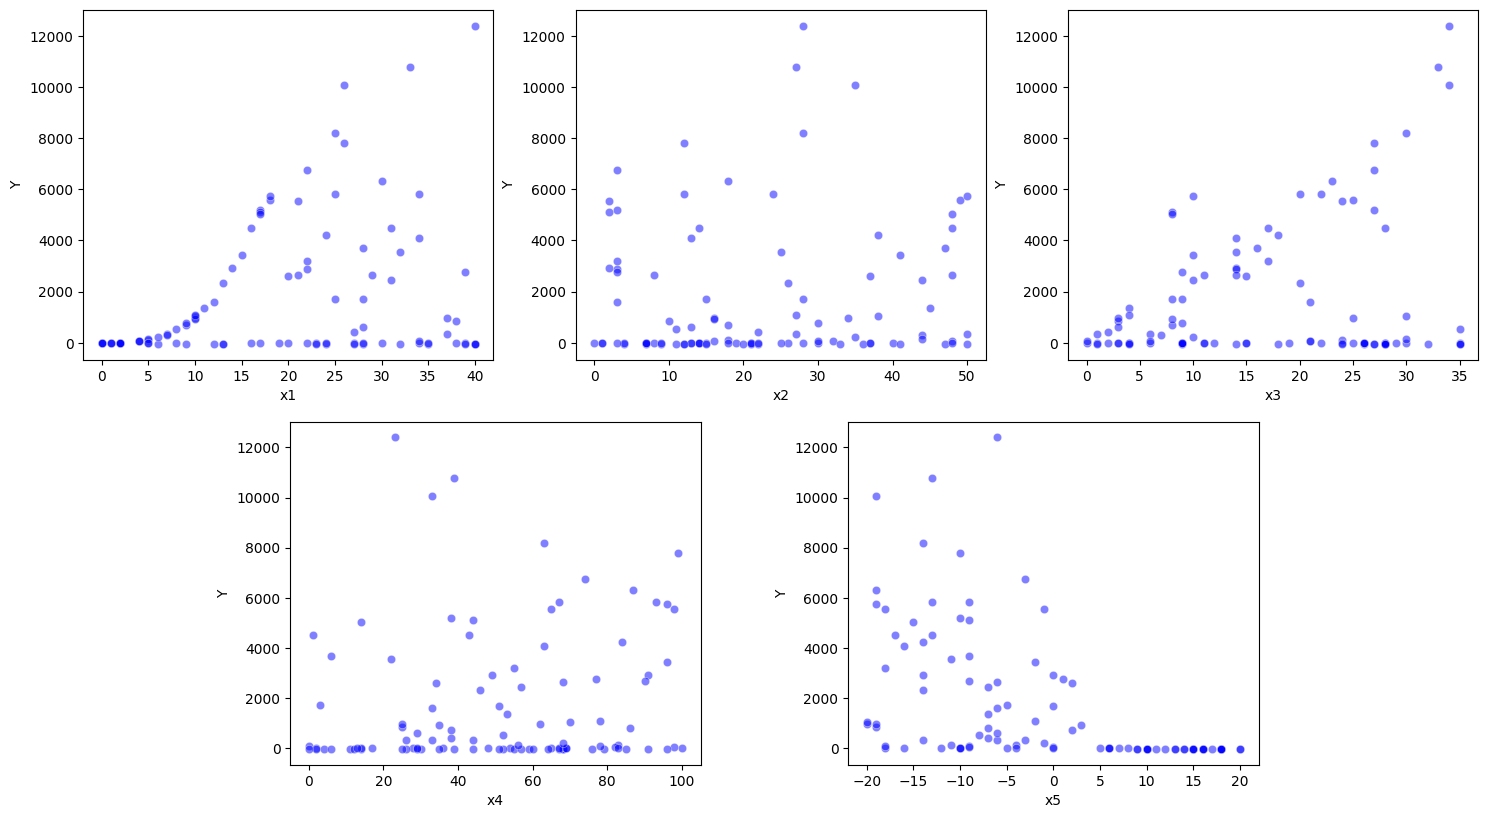

In [178]:
fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
axes_[1][2].set_visible(False)
axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])

for i_ in range(len(predictors)):
    sns.scatterplot(ax=axes_[i_ // 3, i_ % 3], x=dataset[predictors[i_]], y=dataset['Y'], alpha=0.5, color='b')

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

From here, I can see that when x1 has low values, their corresponding Y values are also tend to be lower. Similarly,
when x5 has a value greater than 5, its corresponding Y value is lower. Because of this, I assume that some kind of
classification method must be applied.


,min,max,mean,std
x1,0.0,40.0,19.29,12.315954
x2,0.0,50.0,22.53,15.019486
x3,0.0,35.0,16.68,10.375651
x4,0.0,100.0,50.60,28.242814
x5,-20.0,20.0,-1.44,12.270783
Y,-42.0,12402.0,1746.82,2696.083648


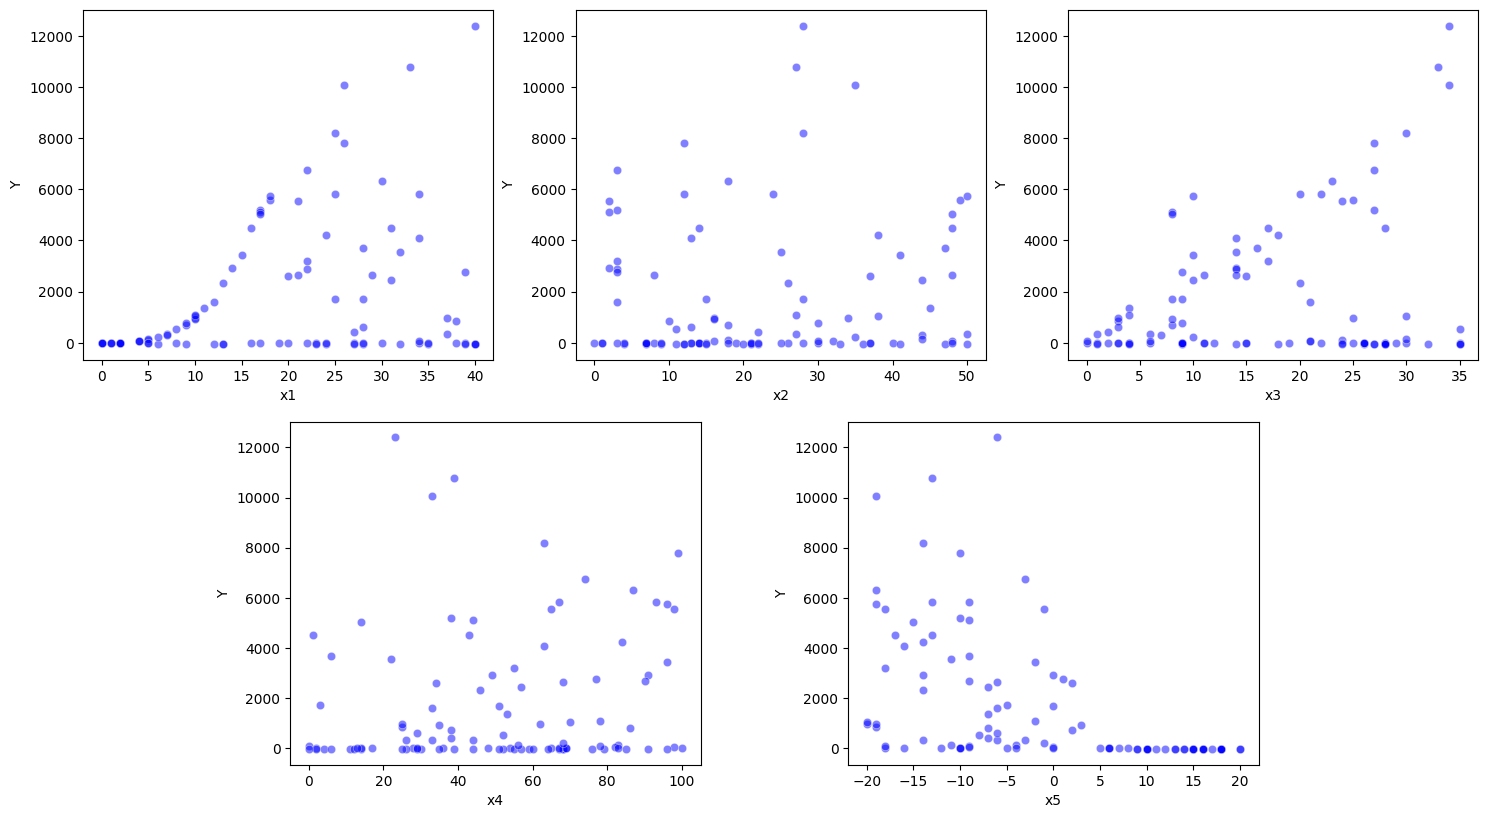

In [179]:
fig_, axes_ = plt.subplots(2, 3, figsize=(18, 10))
axes_[1][2].set_visible(False)
axes_[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes_[1][1].set_position([0.55, 0.125, 0.228, 0.343])

for i_ in range(len(predictors)):
    sns.scatterplot(ax=axes_[i_ // 3, i_ % 3], x=dataset[predictors[i_]], y=dataset['Y'], alpha=0.5, color='b')

table_heuristics = dataset.describe().transpose()[['min', 'max', 'mean', 'std']]
display(table_heuristics)

# I. Linear Regression

## I.I. Single Linear Regression

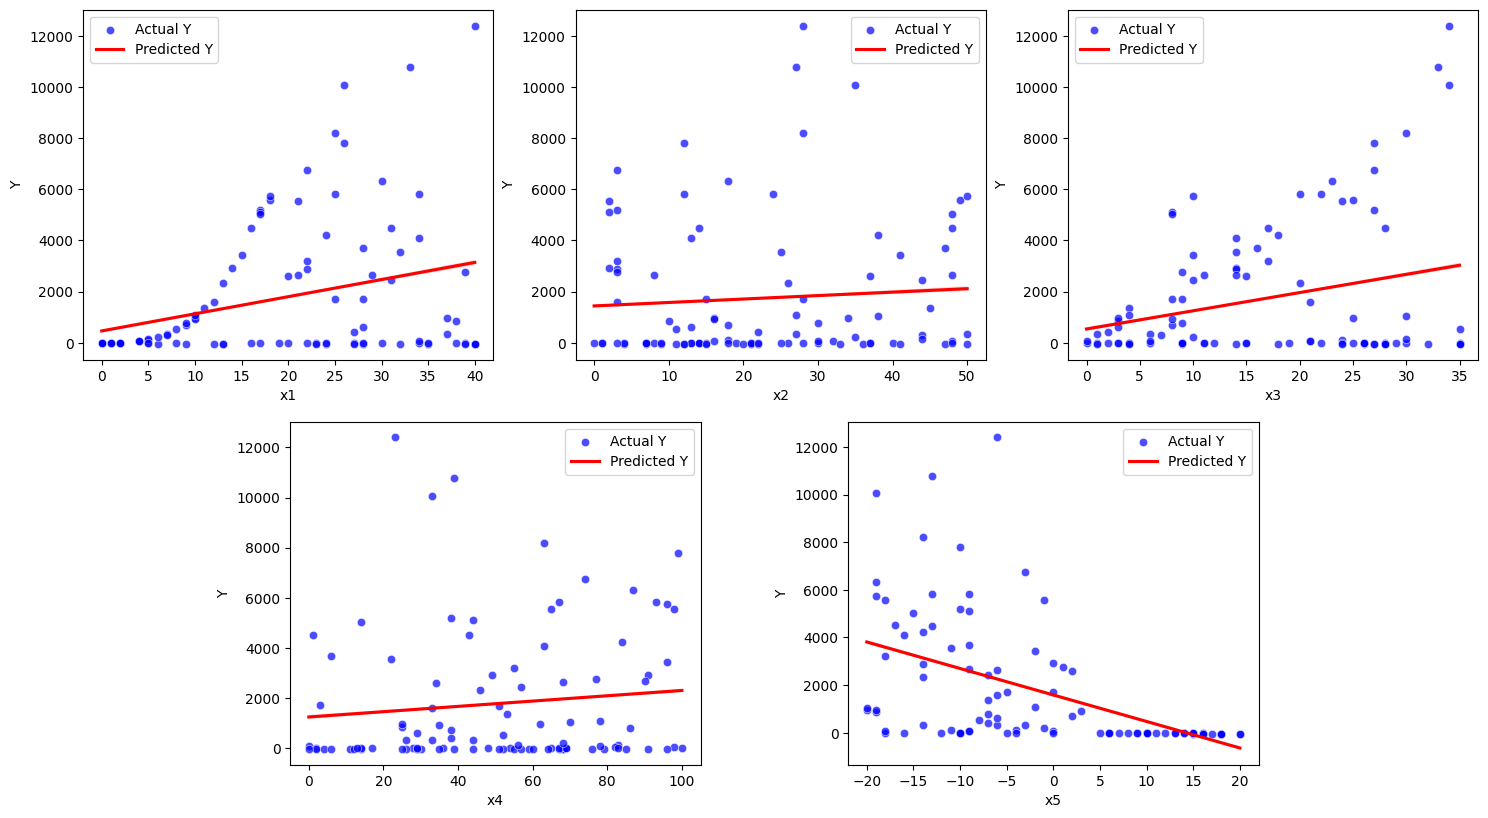

In [180]:
def single_linear_regression(x, y, arg=None, inputs=None):
    cv_scores = cross_val_score(estimator=LinearRegression(),
                                X=pd.DataFrame(x[inputs], columns=[inputs]),
                                y=y,
                                cv=5,
                                scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=pd.DataFrame(x[inputs], columns=[inputs]),
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'single_linear_regression',
                        'arg': '',
                        'predictors': inputs,
                        'predicted': cv_predictions,
                        'error': cv_scores.sum()/len(cv_scores)})


fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes[1][2].set_visible(False)
axes[1][0].set_position([0.24, 0.125, 0.228, 0.343])
axes[1][1].set_position([0.55, 0.125, 0.228, 0.343])

lin_reg_results = []
ax_i = 0
for p in predictors:
    ax = axes[ax_i // 3, ax_i % 3]

    p_lin_reg = single_linear_regression(x=features, y=labels, inputs=p)
    lin_reg_results.append(p_lin_reg)
    sns.scatterplot(ax=ax, x=features[p], y=labels,
                    alpha=0.7, color='b', label='Actual Y')
    sns.regplot(ax=ax, x=features[p], y=p_lin_reg.predicted,
                color='r', scatter=False, label='Predicted Y')
    ax.set_xlabel(p)
    ax.set_ylabel('Y')
    ax.legend()
    ax_i += 1

all_results_table.add_model(lin_reg_results)

## I.II. Multiple Linear Regression

In [181]:
def multiple_linear_regression(x, y, arg=None, inputs=predictors):
    cv_scores = cross_val_score(estimator=LinearRegression(),
                                X=x[inputs],
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=x[inputs],
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'multiple_linear_regression',
                        'arg': '',
                        'predictors': ' '.join(inputs),
                        'predicted': cv_predictions,
                        'error': cv_scores.sum()/len(cv_scores)})


predictor_combinations = []
for L in range(2, len(predictors) + 1):
    predictor_combinations.extend(combinations(predictors, L))

multi_lin_reg_args = list(map(list, predictor_combinations))
multi_lin_reg_results = [multiple_linear_regression(x=features, y=labels, inputs=ps) for ps in multi_lin_reg_args]

all_results_table.add_model(multi_lin_reg_results)

## I.III. Polynomial Regression

In [182]:
def polynomial_regression(x, y, arg=None, inputs=predictors):
    poly_features = PolynomialFeatures(degree=arg, include_bias=False).fit_transform(x[inputs])
    print(x[inputs])
    cv_scores = cross_val_score(estimator=LinearRegression(),
                                X=poly_features,
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=LinearRegression(),
                                       X=poly_features,
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'polynomial_regression',
                        'arg': f'order={arg}',
                        'predictors': ' '.join(inputs),
                        'predicted': cv_predictions,
                        'error': cv_scores.sum()/len(cv_scores)})

poly_reg_args = [2, 3, 4]
poly_reg_results = [polynomial_regression(features, labels, arg=order) for order in poly_reg_args]

all_results_table.add_model(poly_reg_results)

    x1  x2  x3  x4  x5
0    1  37  12  65 -18
1   27  14   6  85  11
2   34  13  14  63 -16
3    5  18  24  83  -4
4   31  44  10  57  -7
..  ..  ..  ..  ..  ..
95  10  27   4  78  -2
96  22   3  17  55 -18
97  23  41  27  25  15
98  19  25   3  39  10
99  27  22   2  38  -7

[100 rows x 5 columns]
    x1  x2  x3  x4  x5
0    1  37  12  65 -18
1   27  14   6  85  11
2   34  13  14  63 -16
3    5  18  24  83  -4
4   31  44  10  57  -7
..  ..  ..  ..  ..  ..
95  10  27   4  78  -2
96  22   3  17  55 -18
97  23  41  27  25  15
98  19  25   3  39  10
99  27  22   2  38  -7

[100 rows x 5 columns]
    x1  x2  x3  x4  x5
0    1  37  12  65 -18
1   27  14   6  85  11
2   34  13  14  63 -16
3    5  18  24  83  -4
4   31  44  10  57  -7
..  ..  ..  ..  ..  ..
95  10  27   4  78  -2
96  22   3  17  55 -18
97  23  41  27  25  15
98  19  25   3  39  10
99  27  22   2  38  -7

[100 rows x 5 columns]


## I.IV. K-Nearest-Neighbors Regression

## I.V. Decision Tree Regression

In [183]:
def decision_tree_regression(x, y, arg=5, inputs=predictors):
    tree_regressor = DecisionTreeRegressor(random_state=0, max_depth=arg)
    cv_scores = cross_val_score(estimator=tree_regressor,
                                X=x[inputs],
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=tree_regressor,
                                       X=x[inputs],
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'decision_tree_regression',
                        'arg': f'max_depth={arg}',
                        'predictors': ' '.join(inputs),
                        'predicted': cv_predictions,
                        'error': cv_scores.sum()/len(cv_scores)})

dec_tree_args = range(1, 6)
dec_tree_results = [decision_tree_regression(features, labels, arg=depth) for depth in dec_tree_args]

all_results_table.add_model(dec_tree_results)

## I.VI. Decision Tree Regression

In [184]:
from sklearn.ensemble import RandomForestRegressor

def random_forest_regression(x, y, arg=None, inputs=predictors):
    tree_regressor = RandomForestRegressor(max_depth=arg, random_state=0, max_features=3)
    cv_scores = cross_val_score(estimator=tree_regressor,
                                X=x[inputs],
                                y=y,
                                cv=5, scoring=ecm)
    cv_predictions = cross_val_predict(estimator=tree_regressor,
                                       X=x[inputs],
                                       y=y,
                                       cv=5)
    return ModelResult({'model': 'random_forest_regression',
                        'arg': f'max_depth={arg}',
                        'predictors': ' '.join(inputs),
                        'predicted': cv_predictions,
                        'error': cv_scores.sum()/len(cv_scores)})

rf_args = range(1, 6)
rand_forest_results = [random_forest_regression(features, labels, arg=depth, inputs=predictors) for depth in rf_args]

all_results_table.add_model(rand_forest_results)

all_results_table.display_error_table(transpose=False)

,model,args,predictors,mean_absolute_error
0,decision_tree_regression,max_depth=5,x1 x2 x3 x4 x5,579.674001
1,random_forest_regression,max_depth=5,x1 x2 x3 x4 x5,914.707833
2,polynomial_regression,order=2,x1 x2 x3 x4 x5,1090.235941
3,multiple_linear_regression,,x1 x2 x3 x4 x5,1511.917632
4,single_linear_regression,,x5,1617.438424


In [185]:
%reload_ext watermark
%watermark -v -m -p sklearn,pandas,numpy,matplotlib,seaborn
%watermark -u -n -t -z

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.3.0

sklearn   : 1.1.1
pandas    : 1.4.2
numpy     : 1.22.4
matplotlib: 3.5.2
seaborn   : 0.11.2

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Last updated: Wed Jun 01 2022 21:33:25Turkey Standard Time

